# Feathering (combination) tests

This notebook presents a series of experiments in single-dish + interferometer combination on "realistic" data.

We're "observing" at 2mm, so a 12m dish has FWHM=40" and a 9m baseline has (theoretical) FWHM 56", assuming (incorrectly...) a gaussian beam

In [1]:
# ipython notebook setup:
%matplotlib inline

In [2]:
import image_registration
from astropy import convolution
import numpy as np
import pylab as pl
from uvcombine.uvcombine import feather_kernel, fftmerge

In [3]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
np.random.seed(0)
im = image_registration.tests.make_extended(imsize=256., powerlaw=1.5)

This is the input image along with its histogram.

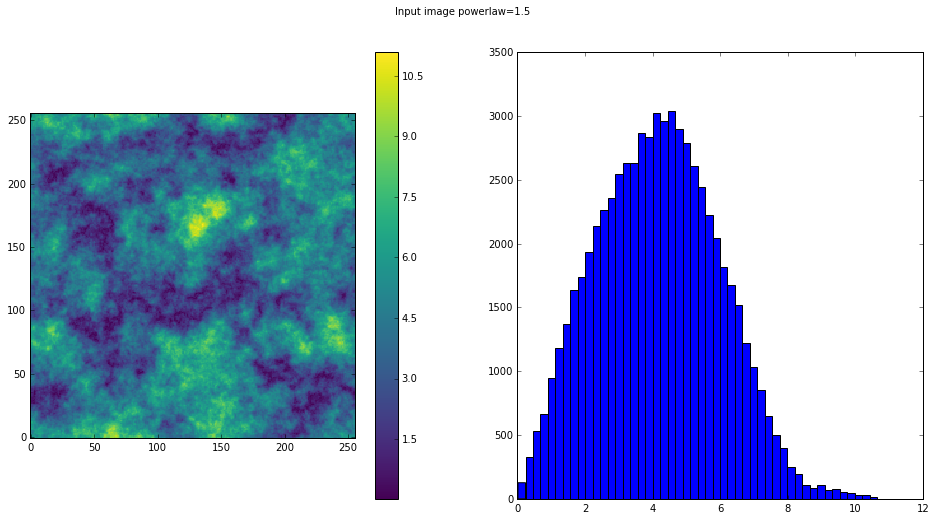

In [4]:
# for each step, we'll save a figure
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(im.ravel(), bins=50)
pl.suptitle("Input image powerlaw=1.5")
pl.savefig("inputimage_pl1.5.png")

In [5]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [6]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map (one period over that map)
# r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)
# We're assuming a pixel scale of 1" / pixel
# therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
# We cut off the "interferometer" at 2.5" resolution
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

The synthetic interferometer's UV coverage map (it's a perfect interferometer)

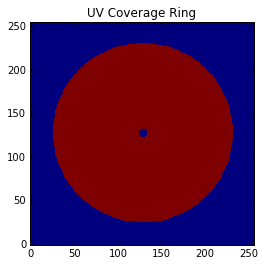

In [7]:
pl.clf()
pl.imshow(ring)
pl.title("UV Coverage Ring")
pl.savefig("uvcoverage_ring.png")

In [8]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

The interferometric image does not preserve total flux, as expected.  Note that the mean of the histogram is shifted.

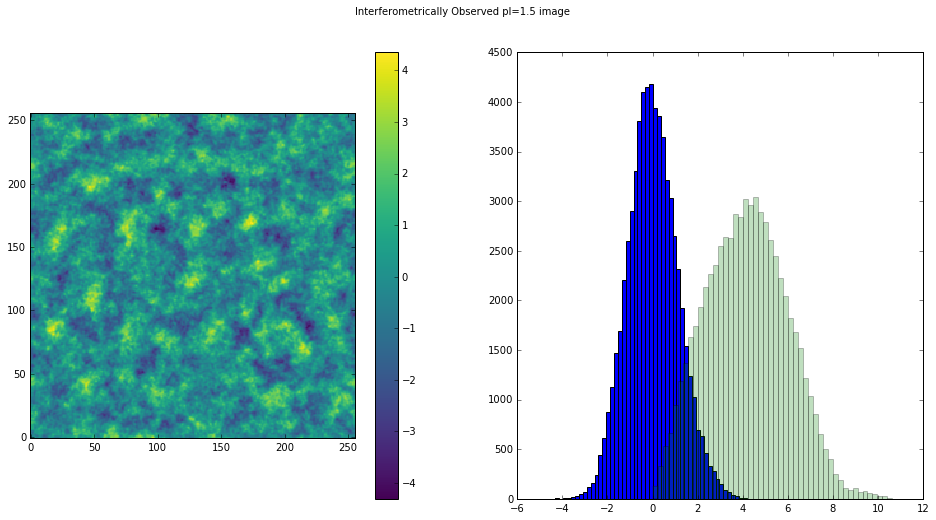

In [9]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Interferometrically Observed pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(im_interferometered.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig("interf_image_pl1.5.png")

The residual of the original image minus the interferometrically observed image.  The large scales and noise are preserved.

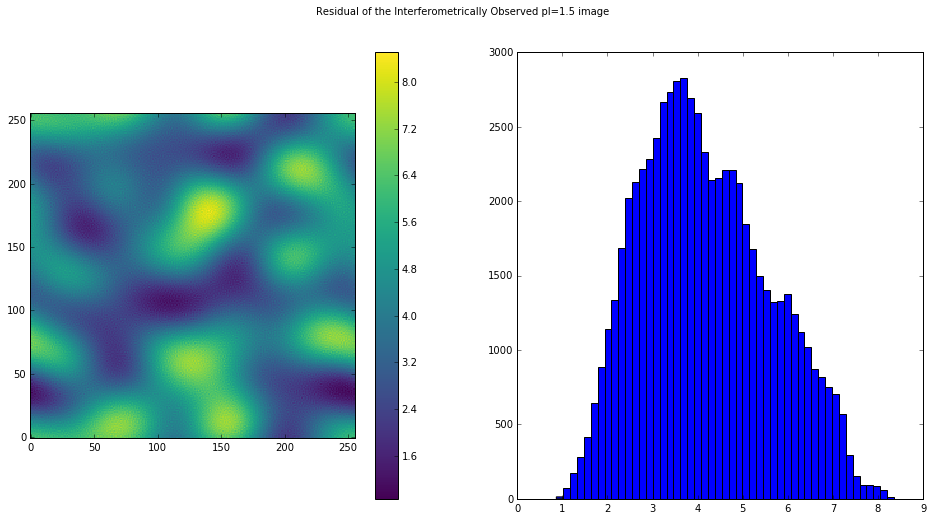

In [10]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-im_interferometered.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Residual of the Interferometrically Observed pl=1.5 image")
pl.subplot(1,2,2)
pl.hist((im-im_interferometered.real).ravel(), bins=50)
pl.savefig("interf_image_pl1.5_residual.png")

The single dish map is just a convolution of the original data with a Gaussian beam.  It preserves flux but loses small scales.

In [11]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(40/2.35),
                                         boundary='fill', fill_value=im.mean())

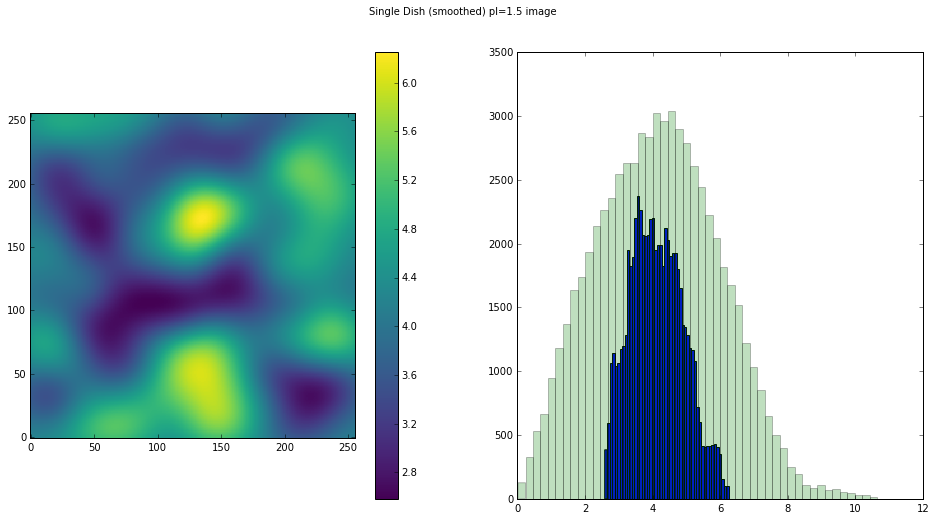

In [12]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(singledish_im, cmap='viridis')
pl.colorbar()
pl.subplot(1,2,2)
pl.hist(singledish_im.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.suptitle("Single Dish (smoothed) pl=1.5 image")
pl.savefig("singledish_image_pl1.5.png")

With this setup, the single dish data looks like a decent match to the interferometer residual.

In [13]:
singledish_kernel = convolution.Gaussian2DKernel(40/2.35, x_size=im.shape[1], y_size=im.shape[0])
singledish_kernel_fft = np.fft.fft2(singledish_kernel)

/Users/adam/anaconda/envs/astropy35/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/adam/anaconda/envs/astropy35/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


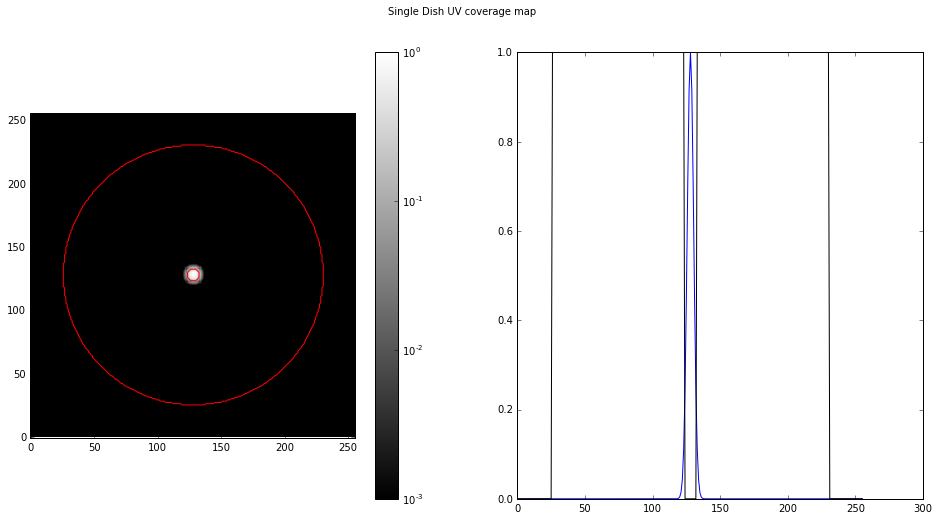

In [14]:
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(np.fft.fftshift(np.abs(singledish_kernel_fft)), cmap='gray',
          norm=pl.matplotlib.colors.LogNorm(),
          vmin=1e-3,
         )
pl.colorbar()
pl.contour(ring, levels=[0.5], colors=['r','r'])
pl.suptitle("Single Dish UV coverage map")
pl.subplot(1,2,2)
pl.plot(np.fft.fftshift(np.abs(singledish_kernel_fft))[im.shape[0]/2,:])
pl.plot(ring[im.shape[0]/2,:], color='k')
pl.savefig("singledish_uvcoverage.png")

In [15]:
# pixel scale can be interpreted as "arcseconds"
# then, fwhm=40 means a beam fwhm of 40"
pixscale = 1
lowresfwhm = 40
nax1,nax2 = im.shape
kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale,)

In [16]:
# Feather the interferometer and single dish data back together
# This uses the naive assumptions that CASA uses
# However, there are a few flags that can be played with.
# None of them do a whole lot, though there are good theoretical
# reasons to attempt them.
im_hi = im_interferometered.real
im_low = singledish_im
lowresscalefactor=1
replace_hires = False
highpassfilterSD = False
deconvSD = False
highresscalefactor=1
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         highpassfilterSD=highpassfilterSD,
                         deconvSD=deconvSD,
                        )

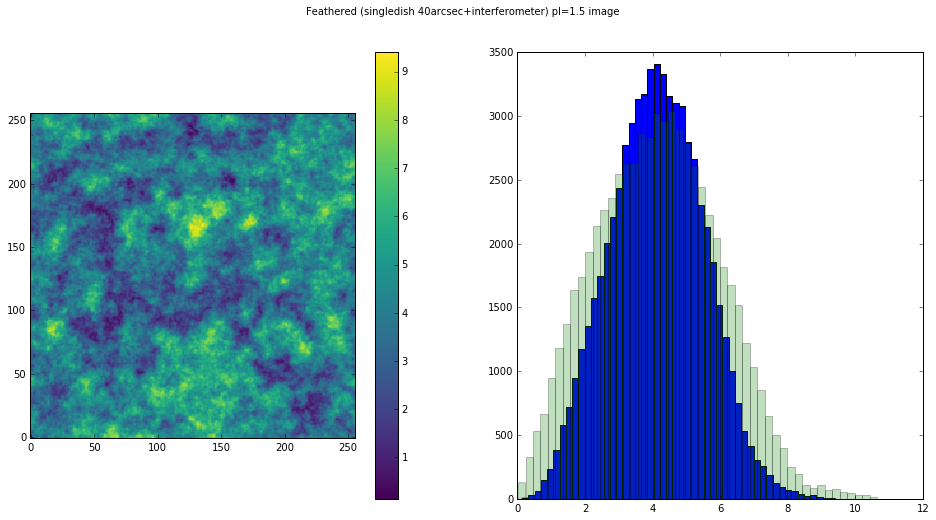

In [17]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(combo.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig("feathered_image_pl1.5.png")

This image looks pretty close to the original, but the peaks and valleys certainly are not recovered (the contrast is reduced compared to the original).

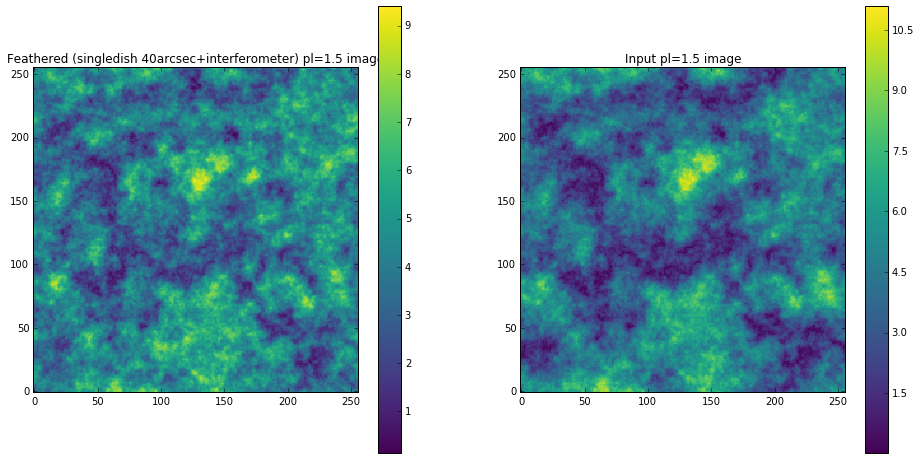

In [18]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")

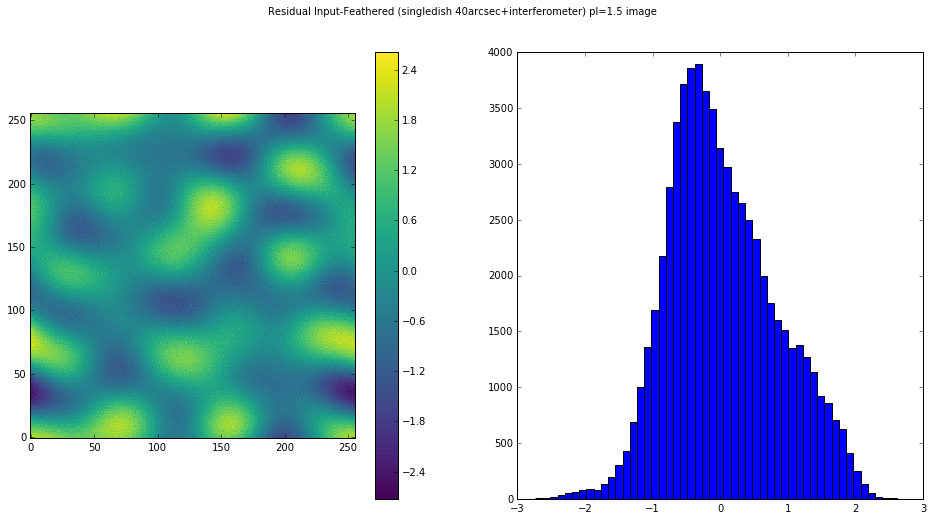

In [19]:
# Residuals (original minus feathered)
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(im-combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Residual Input-Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist((im-combo.real).ravel(), bins=50)
pl.savefig("residual_feathered_image_pl1.5.png")

If we repeat the same experiment again, but with the shortest baseline at 12m instead of 9m, the results are noticeably worse:

In [20]:
largest_scale = 42. # (1.22 * 2*u.mm/(12*u.m)).to(u.arcsec, u.dimensionless_angles())
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

In [21]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [22]:
im_hi = im_interferometered.real
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         highpassfilterSD=highpassfilterSD,
                         deconvSD=deconvSD,
                        )

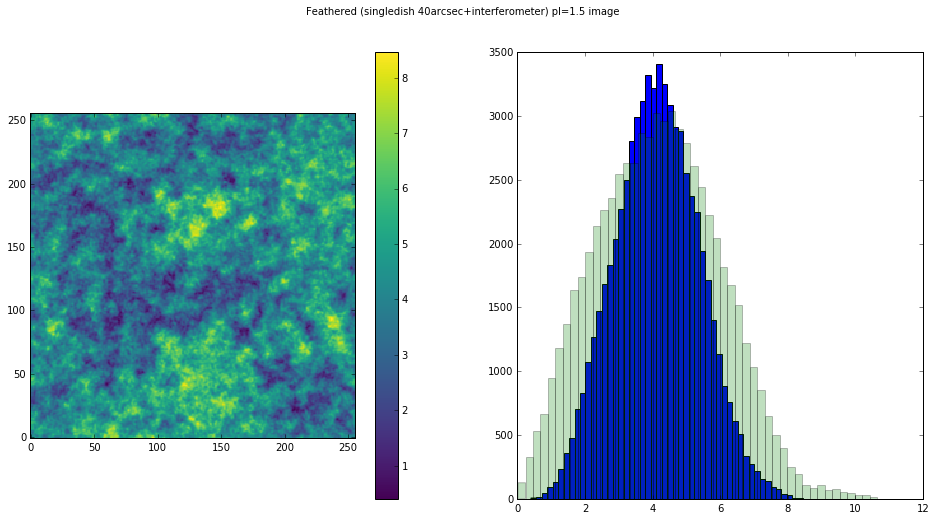

In [23]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.suptitle("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.hist(combo.real.ravel(), bins=50)
pl.hist(im.ravel(), bins=50, alpha=0.25)
pl.savefig("feathered_image_pl1.5_12mshort.png")

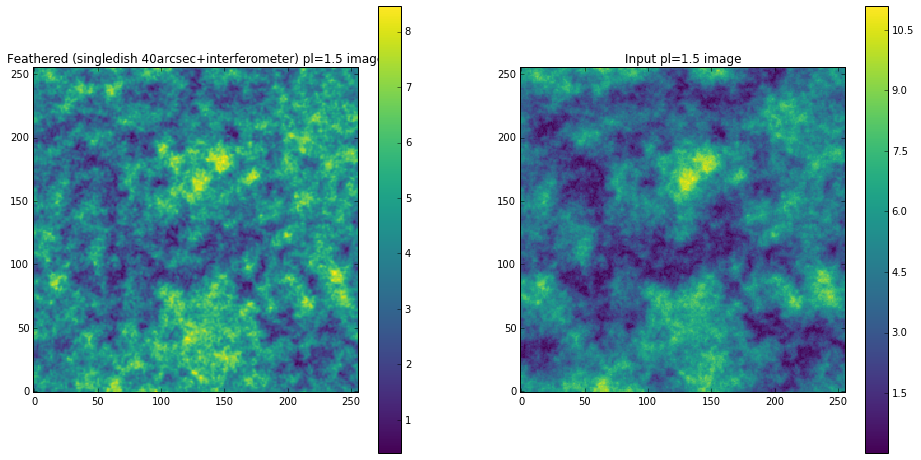

In [24]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,2,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,2,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")

A more realistic interferometer would be helpful.  There is always some tapering or some change of weights between baseline lengths, and that could have a substantial effect.